In [1]:
import tiktoken
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
import pandas as pd

In [2]:
gc.collect()

16

In [3]:
torch.manual_seed(1337)
tokenizer = tiktoken.get_encoding("r50k_base")

In [24]:
context_len = 8
batch_size = 4
train_pct = 0.9
embedding_dim = 32
learning_rate = 1e-3

In [5]:
with open("./data/tiny-shakespeare.txt") as f:
    tiny_shakespeare_lines = f.read()

In [6]:
tokenized_shakespeare_raw = tokenizer.encode(tiny_shakespeare_lines)
tokenized_shakespeare = torch.tensor(tokenized_shakespeare_raw)
decoded_shakespeare = tokenizer.decode(tokenized_shakespeare_raw)

In [7]:
train_n = int(train_pct * len(tokenized_shakespeare))
train_data = tokenized_shakespeare[:train_n]
val_data = tokenized_shakespeare[train_n:]

In [8]:
def get_batch(split):
    data = train_data if split == "train" else val_data
    batch_ind = torch.randint(len(data) - context_len, (batch_size,))
    x = torch.stack([data[i:i+context_len] for i in batch_ind])
    y = torch.stack([data[i+1:i+context_len+1] for i in batch_ind])

    return x, y

In [9]:
class TransformerLM(nn.Module):
    def __init__(self):
        super().__init__()

        self.token_embed = nn.Embedding(tokenizer.n_vocab, embedding_dim)
        self.lm_head = nn.Linear(embedding_dim, tokenizer.n_vocab)

    def forward(self, batch):
        token_embeddings = self.token_embed(batch)
        logits = self.lm_head(token_embeddings)

        return logits

In [30]:
class Trainer:

    def __init__(self, model):
        self.model = model
        self.loss = F.cross_entropy
        self.opt = torch.optim.AdamW(self.model.parameters(), lr=learning_rate)

    def train(self, num_epochs):
        train_losses = []
        val_losses = []
        for epoch in range(num_epochs):
            # Q: why do we sample randomly instead of shuffling the whole dataset?
            train_x, train_y = get_batch("train")
            val_x, val_y = get_batch("val")

            # batch len, context len, num channels
            train_pred_x = self.model(train_x)
            B, T, C = train_pred_x.shape

            train_pred_x = train_pred_x.view(B*T, C)
            train_y = train_y.view(B*T)

            train_loss = self.loss(train_pred_x, train_y)
            self.opt.zero_grad()
            train_loss.backward()
            self.opt.step()


            val_pred_x = self.model(val_x)
            val_pred_x = val_pred_x.view(B*T, C)
            val_y = val_y.view(B*T)
            val_loss = self.loss(val_pred_x, val_y)

            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())

        return pd.DataFrame({
            "train": train_losses,
            "val": val_losses
        })

In [26]:
tlm = TransformerLM()
trainer = Trainer(tlm)

In [29]:
loss_df = trainer.train(2500)

In [31]:
loss_df

,train,val
0,8.172689,9.120704
1,6.615129,8.188423
2,7.810319,7.738827
3,8.562240,8.431386
4,8.839077,8.374770
...,...,...
2495,7.153203,7.327718
2496,6.157735,5.821607
2497,6.159129,6.673354
2498,6.005109,5.694264


<Axes: >

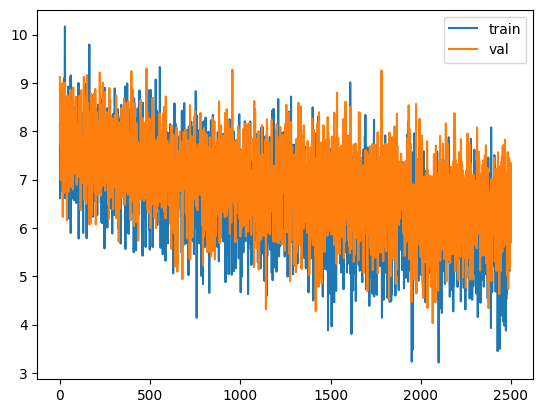

In [32]:
loss_df.plot()

In [43]:
x, y = get_batch("train")

In [40]:
    # def train(self, plot_cadence):
    #     train_dataloader, val_dataloader = self.dataset.get_dataloaders(self.hyperparams["batch_size"])

    #     train_loss_hist = []
    #     val_loss_hist = []
    #     for epoch_num in range(self.hyperparams["num_epochs"]):
    #         for batch_num, (train_data, val_data) in enumerate(zip(train_dataloader, val_dataloader)):
    #             train_X, train_y = train_data
    #             val_X, val_y = val_data

    #             pred_y = self.model(train_X)
    #             loss = self.loss_fn(pred_y, train_y)

    #             self.opt.zero_grad()
    #             loss.backward()
    #             self.opt.step()

    #             val_pred_y = self.model(val_X)
    #             val_loss = self.loss_fn(val_pred_y, val_y)
                
    #             if batch_num % plot_cadence == 0:
    #                 train_loss_hist.append(loss.item())
    #                 val_loss_hist.append(val_loss.item())

    #     pd.DataFrame(dict(train=train_loss_hist, val=val_loss_hist)).plot()